## OG Model

Li Liu

Link to problem sets: https://github.com/OpenSourceEcon/BootCamp2019/blob/master/Econ/Wk4_OG/OG_probset.pdf

In [1]:
import numpy as np
import time
import scipy.optimize as opt
import matplotlib.pyplot as plt
import scipy.linalg as la

In [2]:
# Set params
alpha = .35
delta = 0.6415
beta = 0.442
sigma = 3
A = 1
SS_tol = 0.001
nvec = np.array([1,1,.2])

f_params = (beta, nvec, A, alpha, delta, sigma, SS_tol)

In [158]:
def get_L(nvec):
    '    Labor market clearing  '
    L = np.sum(nvec)
    return L

def get_K(bvec):
    '    Capital market clearing  '   
    K = np.sum(bvec)
    return K

def get_L(nvec):
    '    Capital market clearing  '   
    L = np.sum(nvec)
    return L


def get_r(K,L,f_params):
    '    Firms optimization / interest rate  '     
    beta, nvec, A, alpha, delta, sigma, SS_tol = f_params
    r = alpha*A*np.sign(K/L)*np.abs(K/L)**(alpha-1)-delta
    return r 
    
def get_w(K,L,f_params):
    '    Firms optimization / wages  '        
    beta, nvec, A, alpha, delta, sigma, SS_tol = f_params
    w = (1-alpha)*A*np.sign(K/L)*np.abs(K/L)**(alpha)
    return w

def mUtil(c, sigma):
    mu = np.sign(c)*np.abs(c)**(-sigma)
    return mu



## Exercise 2.1.

In [4]:
def feasible(f_params, bvec_guess):
    ''' Check feasibility for the steady state given a guess for the savings vector b  '''
    
    # initialize
    c = np.zeros(3)
    
    # unpack parameters
    beta, nvec, A, alpha, delta, sigma, SS_tol = f_params
    n1, n2, n3 = nvec
    b2, b3 = bvec_guess
    
    # Initialize the boolians
    K_cnstr, c_cnstr, b_cnstr = np.full(1, False), np.full(3, False), np.full(2, False)
    
    K = get_K(bvec_guess)
    L = get_L(nvec)
    w = get_w(K,L,f_params) #in steady state, they are the same 
    r = get_r(K,L,f_params)
    c[0] = n1*w - b2 
    c[1] = n2*w + (1+r)*b2 - b3
    c[2] = n3*w + (1+r)*b3
          
    K_cnstr[K <= 0] = True
    c_cnstr[c <=0] = True

    for iB in range(3):
        if c_cnstr[iB] == True:
            b_cnstr[0:iB]  == True

    
    return b_cnstr, c_cnstr, K_cnstr

In [5]:
# Part a.

bvec_guess = np.array([1.0, 1.2])
b_cnstr, c_cnstr, K_cnstr = feasible(f_params, bvec_guess)

print('constraint satisfied?')
print('b ', b_cnstr,'c', c_cnstr, 'K',K_cnstr)

constraint satisfied?
b  [False False] c [ True False False] K [False]


In [6]:
# Part b.

bvec_guess = np.array([0.06, -0.001])
b_cnstr, c_cnstr, K_cnstr = feasible(f_params, bvec_guess)

print('constraint satisfied?')
print('b ', b_cnstr,'c', c_cnstr, 'K',K_cnstr)

constraint satisfied?
b  [False False] c [False False False] K [False]


In [7]:
# Part c.

bvec_guess = np.array([0.1, 0.1])
b_cnstr, c_cnstr, K_cnstr = feasible(f_params, bvec_guess)

print('constraint satisfied?')
print('b ', b_cnstr,'c', c_cnstr, 'K',K_cnstr)

constraint satisfied?
b  [False False] c [False False False] K [False]


## Exercise 2.2

In [8]:
def Eul_errs_fn(bvec,f_params):
    # initialize
    EulErr = np.zeros(2)
    c = np.zeros(3)
    
    # unpack parameters
    beta, nvec, A, alpha, delta, sigma, SS_tol = f_params
    n1, n2, n3 = nvec
    b2, b3 = bvec
        
    K = get_K(bvec)
    L = get_L(nvec)
    w = get_w(K,L,f_params) #in steady state, they are the same 
    r = get_r(K,L,f_params)
    
    c[0] = n1*w - b2
    c[1] = n2*w + (1+r)*b2 - b3
    c[2] = n3*w + (1+r)*b3

    EulErr[0] = mUtil(c[0], sigma) - beta*(1+r)*mUtil(c[1], sigma)
    EulErr[1] = mUtil(c[1], sigma) - beta*(1+r)*mUtil(c[2], sigma)
    
    return EulErr

In [9]:
def get_SS(f_params, bvec_guess, SS_graphs=False):
    
    '''
    INPUT : 
        f_arams : a tuple of the parameters for the model
        bvec_guess : an initial guess of the steady-state savings
        SS graphs : generates a figure of the steady-state distribution of consumption
          and savings if it is set to True.
    '''
    
    start_time = time.perf_counter()

    # initialize 
    EulErr_ss = np.zeros(2)
    c_ss = np.zeros(3)
    
    # unpack parameters
    beta, nvec, A, alpha, delta, sigma, SS_tol = f_params
    n1, n2, n3 = nvec
    

    Fn = lambda bvec: Eul_errs_fn(bvec,f_params)
    root_found = opt.root(Fn, bvec_guess, tol=SS_tol)
    
    # Calculate steady-state levels of equilibrium objects
    b_ss = root_found.x
    Euler_ss = root_found.fun
    
    b2, b3 = b_ss

        
    K_ss = get_K(b_ss)
    L_ss = get_L(nvec)
    w_ss = get_w(K_ss,L_ss,f_params) #in steady state, they are the same 
    r_ss = get_r(K_ss,L_ss,f_params)
    
    c_ss[0] = n1*w_ss - b2
    c_ss[1] = n2*w_ss + (1+r_ss)*b2 - b3
    c_ss[2] = n3*w_ss + (1+r_ss)*b3
        
    Y_ss = A*(K_ss)**alpha*L_ss**(1-alpha)
    C_ss = np.sum(c_ss)

    
    RCerr_ss =  Y_ss - C_ss - delta*K_ss
    
    if SS_graphs == True:
        fig, ax = plt.subplots(figsize=(4,4))
        s = range(3)
        plt.plot(s, c_ss, label=r'$\bar{c}_s$', marker='o')
        plt.plot(s[1:], b_ss, label=r'$\bar{b}_s$', marker='o')
        plt.title("Steady-State Consumption and Savings")
        plt.legend()
        plt.grid()
        plt.xlabel("Cohort")
        plt.ylabel("Level")
        plt.xticks(s)
        plt.show()

    ss_time = time.perf_counter()
    ss_output = {'b_ss': b_ss, 'c_ss': c_ss, 'w_ss': w_ss, \
                 'r_ss': r_ss,'K_ss': K_ss, 'Y_ss': Y_ss, 'C_ss': C_ss, 'EulErr_ss': EulErr_ss, 'RCerr_ss': RCerr_ss,'ss_time': ss_time}
        
    return ss_output

In [25]:
# Part a.

# Set params
alpha = .35
delta = 0.6415
beta = .442
sigma = 3
A = 1
SS_tol = 0.001
nvec = np.array([1,1,.2])
f_params = (beta, nvec, A, alpha, delta, sigma, SS_tol)

#
results_ss = get_SS(f_params, np.array([.1, .1]))
print(results_ss)

{'b_ss': array([0.01931262, 0.05841243]), 'c_ss': array([0.18241333, 0.20961424, 0.24087656]), 'w_ss': 0.20172594930955895, 'r_ss': 2.433025771148647, 'K_ss': 0.07772504796372812, 'Y_ss': 0.6827647515092765, 'C_ss': 0.6329041332405448, 'EulErr_ss': array([0., 0.]), 'RCerr_ss': 9.020562075079397e-17, 'ss_time': 328.611962587}


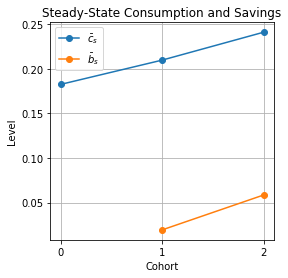

In [11]:
# Part b.

results_ss = get_SS(f_params, np.array([.1, .1]), True)

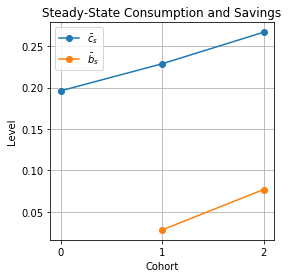

{'b_ss': array([0.02817667, 0.07686515]), 'c_ss': array([0.19597511, 0.22861536, 0.26669277]), 'w_ss': 0.22415178438531141, 'r_ss': 1.8863851251981048, 'K_ss': 0.10504181919699425, 'Y_ss': 0.7586675779195158, 'C_ss': 0.6912832509046438, 'EulErr_ss': array([0., 0.]), 'RCerr_ss': 1.5265566588595902e-16, 'ss_time': 197.636353495}


In [22]:
# Part c.

# Set params
N_gen = 20
alpha = .35
delta = 0.6415
beta = .55
sigma = 3
A = 1
SS_tol = 0.001
f_params = (beta, nvec, A, alpha, delta, sigma, SS_tol)
guess = np.array([.01, .01])

#
results_ss = get_SS(f_params, guess, True)
print(results_ss)

### Conclusion

- With higher discount rate, agents become more patient. They save more and consume later in their life  

In [100]:
b2bar, b3bar = results_ss.get("b_ss")

print('b2 st. state:', round(b2bar,4))

b2 st. state: 0.0193


## Exercise 2.3. Time Path Iteration

In [85]:
def Eul_b32_fn(b32, b21,r, w, f_params):
    '''
    r is a 2x1 array of interet rates
    w is a 2x1 array of interet rates    
    b21 is already established by the guess
    plug this fn into a root-finder to solve for b32
    '''
    
    # unpack parameters
    beta, nvec, A, alpha, delta, sigma, SS_tol = f_params
    n1, n2, n3 = nvec
    r1, r2 = r
    w1, w2 = w
            
    c21 = n2*w1 +(1+r1)*b21 - b32
    c32= n3*w2 + (1+r2)*b32

    EulErr = mUtil(c21, sigma) - beta*(1+r2)*mUtil(c32, sigma)
    
    return EulErr

def Eul_b22b33_fn(bvec,r,w, f_params):
    '''
    r is a 3x1 array of interet rates
    w is 3x1 array
    '''    
    EulErr = np.zeros(2)
    # unpack parameters
    beta, nvec, A, alpha, delta, sigma, SS_tol = f_params
    n1, n2, n3 = nvec
    r2, r3 = r
    w1, w2, w3 = w
    b22, b33 = bvec
            
    c12 = n1*w1  - b22   
    c23= n2*w2 + (1+r2)*b22 - b33        
    c33 = n3*w3 + (1+r3)*b33

    EulErr[0] = mUtil(c12, sigma) - beta*(1+r2)*mUtil(c23, sigma)
    EulErr[1] = mUtil(c23, sigma) - beta*(1+r3)*mUtil(c33, sigma)
    return EulErr

def eul_b2t_b3t1(bvec, err2_args):
    """Solve for b_{2,t} and b_{3,t+1} for t=3,...,T+1 using two
    intertemporal Euler Equations.
    
    Parameters:
        bvec: a 2 element numpy array with a guess for the savings vector
        that satisfies the intertemporal Euler equations
        err2_args: a tuple with the model parameters beta, sigma, rpath, wpath, nvec
        
    Returns:
        err1: (float) error in intertemporal Euler equation from using bvec
        err2: (float) error in intertemporal Euler equation from using bvec
    
    """
    
    # rpath has two elements: r_2 and r_3
    # wpath has three elements: w_1, w_2, and w_3
    beta, sigma, rpath, wpath, nvec = err2_args 
    
    # Calculate consumption in each period from budget constraints
    c1 = nvec[0] * wpath[0] - bvec[0]
    c2 = nvec[1] * wpath[1] + (1 + rpath[0]) * bvec[0] - bvec[1]
    c3 = (1 + rpath[1]) * bvec[1] + nvec[2] * wpath[2]
    
    # Calculate marginal utility of consumption
    MU1 = c1 ** (-sigma)
    MU2 = c2 ** (-sigma)
    MU3 = c3 ** (-sigma)
    
    # Calculate error from intertemporal Euler Equations
    err1 = MU1 - beta * (1 + rpath[0]) * MU2
    err2 = MU2 - beta * (1 + rpath[1]) * MU3
    
    return err1, err2

In [86]:
# Set params
alpha = .35
delta = 0.6415
beta = .442
sigma = 3
A = 1
SS_tol = 0.001
nvec = np.array([1,1,.2])
f_params = (beta, nvec, A, alpha, delta, sigma, SS_tol)

# Set add. parameters
T = 2
path_tol = 1e-9
xi = .8
maxIter = 100
eps = path_tol + 100
bvec_guess = np.array([.1, .1])


In [157]:
counter = 0
max_AbsEulErrs = np.zeros(maxIter)
# Get the Steady State
results_ss = get_SS(f_params, bvec_guess, False)
bbar = results_ss["b_ss"]
Kbar = results_ss['K_ss']
rbar = results_ss['r_ss']
wbar = results_ss['w_ss']

# Guess initial transition path (linear for K) and initialize 
bvec_new, EulErrs = np.zeros((T+1,2)), np.zeros((T+1,2))
Kpath_new,Ct, Yt, Res  = np.zeros(T),np.zeros(T),np.zeros(T),np.zeros(T)
# Set b21, b31 
bvec_new[0,:] = .8 * bbar[0], 1.1 * bbar[1]
b21 = bvec_new[0,0]

K1 = get_K(bvec_new[0,:])

Kpath = np.linspace(K1, Kbar, T)
Kpath = np.append(Kpath, Kbar)
L = get_L(nvec)

# Get wage and interest rate paths in starting iteration
rpath = get_r(Kpath, L, f_params)
wpath = get_w(Kpath, L, f_params)
rpath = np.append(rpath,rbar) # add sth for T+1 period 
wpath = np.append(wpath,wbar) # add sth for T+1 period 

# unpack parameters
beta, nvec, A, alpha, delta, sigma, SS_tol = f_params
n1, n2, n3 = nvec

# Solve for time-path equilibrium of aggregate capital
while (counter < maxIter and eps > path_tol):    
    # Solve for b32,     #b32, b21 given from bvec_new
    f = lambda b32: Eul_b32_fn(b32,b21,rpath[0:2], wpath[0:2], f_params) 
    root_f1 = opt.root(f, .1, tol=SS_tol) # b32_guess = .1

    bvec_new[1,1] = root_f1.x
    EulErrs[1,1] = root_f1.fun
    Kpath_new[0] = get_K(bvec_new[0,:])
    
    # Solve for b_{2,t} and b_{3,t+1} using the twisted donut method
    for tT in range(1,T):
        # Solve second set of Eul. Eqs b22,b33
        f2 = lambda bvec: Eul_b22b33_fn(bvec,rpath[tT:tT+2],wpath[tT-1:tT+2], f_params)
        root_f2 = opt.root(f2, bvec_guess, tol=SS_tol)
        bvec_new[tT,0] = root_f2.x[0]
        bvec_new[tT+1,1] = root_f2.x[1]
        # Collect Euler errors
        EulErrs[tT,0] = root_f2.fun[0]
        EulErrs[tT+1,1] = root_f2.fun[1]
        
        # Calculate new aggregate capital levels
        Kpath_new[tT] = get_K(bvec_new[tT,:])
        
        #Calculate agg consumpiton 
        b2t = bvec_new[tT,0]
        b3t = bvec_new[tT,1]
        r = rpath[tT]
        w = wpath[tT]

        c1t = nvec[0] * w - b2t
        c2t = nvec[1] * w + (1 + r) * b2t - b3t
        c3t = nvec[2] * w + (1 + r) * b3t
        Ct[tT] = c1t + c2t + c3t
        Yt[tT] = A * (Kpath[tT] ** alpha) * (L **(1 - alpha))
        Res[tT] = Yt[tT]- Ct[tT] - Kpath[tT-1] + (1-delta)*Kpath[tT]
        
    # Calculate maximum of the absolute values of all the Euler 
    # errors across the entire time path.
    max_AbsEulErrs[counter]= np.amax(np.abs(EulErrs))
          
    # Calculate difference from last capital series
    eps = la.norm(Kpath[0:T] - Kpath_new[0:T],2)
    
    # Update capital series
    Kpath[0:T] = xi*Kpath_new[0:T] + (1-xi)* Kpath[0:T] 
   
    # Update interest rates and wages
    rpath[0:T] = get_r(Kpath[0:T], L, f_params)
    wpath[0:T] = get_w(Kpath[0:T], L, f_params)

    counter = counter + 1
    print('counter:',counter,'eps_tol:',eps)
    
eps = 100
bpath = bvec_new.copy()
Ct[tT] = c1t + c2t + c3t
Yt[tT] = A * (Kpath[tT] ** alpha) * (L **(1 - alpha))
Res[tT] = Yt[tT]- Ct[tT] - Kpath[tT-1] + (1-delta)*Kpath[tT]


counter: 1 eps_tol: 0.005204141974155501
counter: 2 eps_tol: 0.002111012582797936
counter: 3 eps_tol: 0.0010888211396958229
counter: 4 eps_tol: 0.0005833555881645702
counter: 5 eps_tol: 0.00031629689313023354
counter: 6 eps_tol: 0.00017243146880500186
counter: 7 eps_tol: 9.426734267317916e-05
counter: 8 eps_tol: 5.1609226297490424e-05
counter: 9 eps_tol: 2.8270603487580528e-05
counter: 10 eps_tol: 1.548495629356614e-05
counter: 11 eps_tol: 8.476750845172893e-06
counter: 12 eps_tol: 4.635472288187141e-06
counter: 13 eps_tol: 2.53110016833337e-06
counter: 14 eps_tol: 1.3793255772703782e-06
counter: 15 eps_tol: 7.497401192741561e-07
counter: 16 eps_tol: 4.0615456044135106e-07
counter: 17 eps_tol: 2.1903826096351374e-07
counter: 18 eps_tol: 1.1742207819478046e-07
counter: 19 eps_tol: 6.245933879217622e-08
counter: 20 eps_tol: 3.2900292737482435e-08
counter: 21 eps_tol: 1.7127981354419956e-08
counter: 22 eps_tol: 8.797343022817969e-09
counter: 23 eps_tol: 4.451793765646834e-09
counter: 24 e

### Part a.


In [164]:
max_error =np.amax(np.abs(EulErrs))
print('Max Abs Euler Error:', round(np.amax(np.abs(EulErrs)),8))
max_res_error =np.amax(np.abs(Res))
print('Max Resource Const. Error:', round(np.amax(np.abs(Res)),8))


Max Abs Euler Error: 0.00080665
Max Resource Const. Error: 0.00433057


Text(0.5, 1.0, 'Int. Rate')

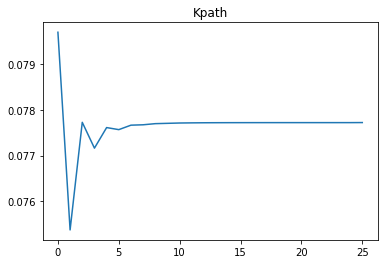

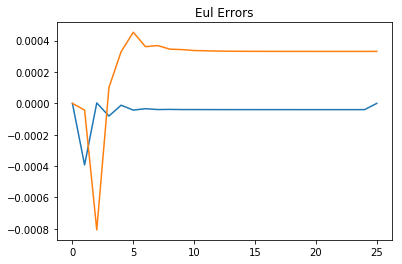

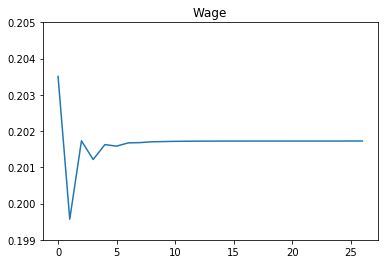

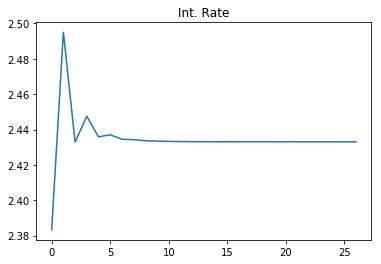

In [188]:
# Plot solution
plt.figure()
plt.plot(range(T+1),Kpath)
plt.title('Kpath')
plt.figure()
plt.plot(range(T+1),EulErrs)
plt.title('Eul Errors')
plt.figure()
plt.plot(range(T+2),wpath)
plt.ylim(0.199, 0.205)
plt.title('Wage')
plt.figure()
plt.plot(range(T+2),rpath)
plt.title('Int. Rate')


### c.  How many periods did it take for the economy to get within 0.00001 of the steady-state aggregate capital stock $\bar{K}$?


In [201]:
DistToKbar = np.abs(Kpath - Kbar)
ConvPoint = np.where(DistToKbar < .00001)[0]
print('Kbar converges to the steady state at t = ',ConvPoint[0])
print(ConvPoint)
print('The path converges permanently after period', 10)

Kbar converges to the steady state at t =  2
[ 2 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25]
The path converges permanently after period 10


# Chapter 3 - S-period lived

## Problem 3.2


In [159]:
def Eul_errs_fn_S(bvec,S,f_params):
    # initialize
    bvec = np.insert(bvec, 0, 0)
    EulErr = np.zeros(S-1)
    c = np.zeros(S)
    # unpack parameters
    beta, nvec, A, alpha, delta, sigma, SS_tol = f_params

    K = get_K(bvec)
    L = get_L(nvec)
    w = get_w(K,L,f_params) #in steady state, they are the same 
    r = get_r(K,L,f_params)
    
    c = find_c(nvec,bvec,w,r,f_params)
    
    for sS in range(S-1):    
        EulErr[sS] = mUtil(c[sS], sigma) - beta**(80/S)*(1+r)*mUtil(c[sS+1], sigma)       
    
    return EulErr

In [160]:
def find_c(nvec,bvec,w,r,f_params):
    beta, nvec, A, alpha, delta, sigma, SS_tol = f_params
    c = np.zeros(S)

    c[0] = nvec[0]*w - bvec[1]
    for sS in range(1,S-1):        
        c[sS] = nvec[sS]*w + (1+r)*bvec[sS] - bvec[sS+1]
    c[S-1] = nvec[S-1]*w + (1+r)*bvec[S-1] #index S-1 in python is S-th position
    return c

In [161]:
def get_SS_S(f_params, S, bvec_guess, SS_graphs=False):
    
    '''
    INPUT : 
        f_arams : a tuple of the parameters for the model
        bvec_guess : an initial guess of the steady-state savings
        SS graphs : generates a figure of the steady-state distribution of consumption
          and savings if it is set to True.
    '''
    
    start_time = time.perf_counter()
    # initialize 
    EulErr_ss = np.zeros(S-1)
    c_ss = np.zeros(S)
    
    # unpack parameters
    beta, nvec, A, alpha, delta, sigma, SS_tol = f_params
    
    # Solve for the optimal bvec    
    Fn = lambda bvec: Eul_errs_fn_S(bvec,S,f_params)
    root_found = opt.root(Fn, bvec_guess, tol=SS_tol)

    # Calculate steady-state levels of equilibrium objects
    b_ss = root_found.x
    Euler_ss = root_found.fun
        
    K_ss = get_K(b_ss)
    L_ss = get_L(nvec)
    w_ss = get_w(K_ss,L_ss,f_params) #in steady state, they are the same 
    r_ss = get_r(K_ss,L_ss,f_params)
    c_ss = find_c(nvec,np.append(0,b_ss),w_ss,r_ss,f_params)
    Y_ss = A*(K_ss)**alpha*L_ss**(1-alpha)
    C_ss = np.sum(c_ss)

    RCerr_ss =  Y_ss - C_ss - delta*K_ss
    
    if SS_graphs == True:
        fig, ax = plt.subplots(figsize=(6,6))
        s = range(S)
        plt.plot(s, c_ss, label=r'$\bar{c}_s$')
        plt.plot(s[1:], b_ss, label=r'$\bar{b}_s$')
        plt.title("Steady-State Consumption and Savings")
        plt.legend()
        plt.grid()
        plt.xlabel("Cohort")
        plt.ylabel("Level")
        plt.show()

    ss_time = time.perf_counter()
    ss_output = {'b_ss': b_ss, 'c_ss': c_ss, 'w_ss': w_ss, \
                 'r_ss': r_ss,'K_ss': K_ss, 'Y_ss': Y_ss, 'C_ss': C_ss, 'EulErr_ss': EulErr_ss, 'RCerr_ss': RCerr_ss,'ss_time': ss_time}
        
    return ss_output

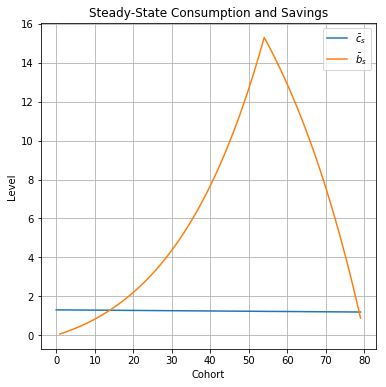

{'b_ss': array([ 0.06304188,  0.12995367,  0.20086131,  0.276124  ,  0.35559185,
         0.43956212,  0.52820088,  0.62168501,  0.72019764,  0.82392885,
         0.93307598,  1.0478439 ,  1.16844529,  1.29510094,  1.42804005,
         1.56750059,  1.71372958,  1.86698347,  2.02752849,  2.19564102,
         2.37160799,  2.55572727,  2.74830809,  2.94967146,  3.16015066,
         3.38009165,  3.6098536 ,  3.84980938,  4.10034607,  4.36186552,
         4.63478491,  4.91953731,  5.21657232,  5.52635669,  5.84937495,
         6.18613013,  6.53714443,  6.90295997,  7.28413954,  7.6812674 ,
         8.09495008,  8.52581723,  8.97452255,  9.44174462,  9.92818794,
        10.43458385, 10.96169158, 11.51029932, 12.08122531, 12.675319  ,
        13.29346223, 13.93657047, 14.60559398, 15.30151973, 14.93264549,
        14.55112095, 14.15639504, 13.74801876, 13.32545873, 12.88816545,
        12.43557875, 11.96711492, 11.48216574, 10.98009951, 10.46026109,
         9.92197106,  9.36452472,  8.787190

In [164]:
# Set params
alpha = .35
delta = .05
#0.6415
beta = 0.96
sigma = 3
A = 1
SS_tol = 0.001

nvec = np.zeros(S)
# construct labour suppy (We assume the individuals supply 
# a unit of labor inelastically in the first two thirds of life) 
# and are retired during the last third of life

for sS in range(S):
    if sS <= np.round(2*S/3):
        nvec[sS] = 1
    else: 
        nvec[sS] = .2

f_params = (beta, nvec, A, alpha, delta, sigma, SS_tol)
bvec_guess = np.ones(S-1)*.1
get_SS_S(f_params, S, bvec_guess, SS_graphs=True)

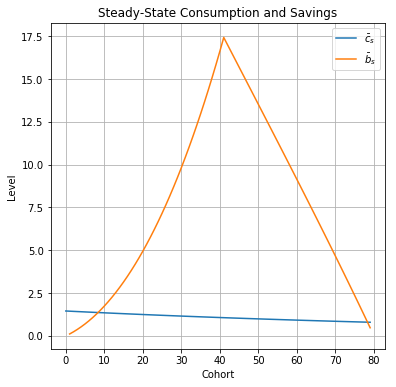

{'b_ss': array([ 0.11348063,  0.2400637 ,  0.37993169,  0.5331482 ,  0.69987552,
         0.88038011,  1.07477931,  1.28324538,  1.50595394,  1.74308436,
         1.99481992,  2.2613478 ,  2.54285916,  2.83954926,  3.15161744,
         3.47926727,  3.82270658,  4.18214755,  4.55780676,  4.94990532,
         5.35866887,  5.78432774,  6.22711695,  6.68727637,  7.16505073,
         7.66068977,  8.17444829,  8.70658624,  9.25736884,  9.82706665,
        10.41595568, 11.02431744, 11.65243899, 12.30061289, 12.96913706,
        13.65831512, 14.36845958, 15.09988983, 15.85292322, 16.62789199,
        17.42513368, 16.99012064, 16.55527548, 16.12053965, 15.68587093,
        15.25119591, 14.81646615, 14.38162987, 13.94662107, 13.51136864,
        13.0758032 , 12.63985848, 12.20347031, 11.76657528, 11.32910981,
        10.89100955, 10.45220913, 10.012642  ,  9.57224044,  9.1309355 ,
         8.6886571 ,  8.24533398,  7.80089382,  7.35526326,  6.90836794,
         6.4601326 ,  6.01048115,  5.559336

In [165]:
S = 80
nvec = np.zeros(S)

for sS in range(S):
    if sS <= np.round(S/2):
        nvec[sS] = 1
    else: 
        nvec[sS] = .2
        
f_params = (beta, nvec, A, alpha, delta, sigma, SS_tol)
bvec_guess = np.ones(S)*.1
get_SS_S(f_params, S, bvec_guess[1:], SS_graphs=True)

With earlier retirement we notice that:

+ The wage rate increases. This is expected, as the decrease in aggregate labour supply should push prices up

+ Steady state capital level increases. This can possibly be explained by substituting labour with capital due to the higher labour costs 

+ GDP and Consumpiotn decrease. This is possibly due to the decreased production d

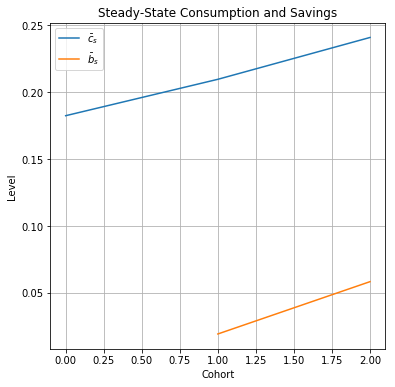

{'b_ss': array([0.01931262, 0.05841243]),
 'c_ss': array([0.18241333, 0.20961424, 0.24087656]),
 'w_ss': 0.20172594930955895,
 'r_ss': 2.433025771148647,
 'K_ss': 0.07772504796372812,
 'Y_ss': 0.6827647515092765,
 'C_ss': 0.6329041332405448,
 'EulErr_ss': array([0., 0.]),
 'RCerr_ss': 9.020562075079397e-17,
 'ss_time': 5735.98250052}

In [111]:
# Check if I get the same results as before when I set S = 3 

# Set params
alpha = .35
delta = 0.6415
beta = 0.96
sigma = 3
A = 1
SS_tol = 0.001

S = 3
nvec = np.zeros(S)
# construct labour suppy (We assume the individuals supply 
# a unit of labor inelastically in the first two thirds of life) 
# and are retired during the last third of life

S = 80
nvec = np.zeros(S)

for sS in range(S):
    if sS <= np.round(2*S/3):
        nvec[sS] = 1
    else: 
        nvec[sS] = .2
        
nvec = np.array([1,1,.2])

f_params = (beta, nvec, A, alpha, delta, sigma, SS_tol)
bvec_guess = np.ones(S)*.1
get_SS_S(f_params, S, bvec_guess[1:], SS_graphs=True)